<a href="https://colab.research.google.com/github/shagufta24/DribbleAI/blob/main/DribbleAI_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ball Action Tracking

## Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from timm.layers import DropPath, create_conv2d, get_act_layer, get_norm_act_layer
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import cv2
import json
import numpy as np
from glob import glob
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import LambdaLR
import math
from sklearn.metrics import f1_score
from tqdm import tqdm
from sklearn.metrics import (
    average_precision_score,
    balanced_accuracy_score,
    matthews_corrcoef,
    f1_score
)
from torch.utils.checkpoint import checkpoint_sequential
import wandb
import matplotlib.pyplot as plt
import random
from torch.cuda.amp import autocast, GradScaler
from torch.utils.checkpoint import checkpoint_sequential
import albumentations as A
import torchvision.transforms as T

In [ ]:
target_path = "/content/drive/MyDrive/Dribble.AI"
link_path = "/content/Dribble.AI"
if not os.path.exists(link_path):
    if os.path.exists(target_path):
        os.symlink(target_path, link_path)
        print(f"Symbolic link created: {link_path} -> {target_path}")
    else:
        print(f"Error: Target directory does not exist: {target_path}")
else:
    print(f"Symbolic link already exists: {link_path}")
os.chdir(link_path)
!pwd

Symbolic link created: /content/Dribble.AI -> /content/drive/MyDrive/Dribble.AI
/content/drive/.shortcut-targets-by-id/1owggVSlCDelGnH8doMz2e4W_dJgMpU5X/Dribble.AI


## Model Architecture

In [ ]:
# --- GeM pooling (unchanged) ---
class GeM(nn.Module):
    def __init__(self, p=3.0, eps=1e-6):
        super().__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        x = x.clamp(min=self.eps).pow(self.p)
        x = F.adaptive_avg_pool2d(x, 1).pow(1.0 / self.p)
        return x.view(x.size(0), -1)

# --- SE block for 3D ---
class SqueezeExcite3d(nn.Module):
    def __init__(self, in_ch, reduction=24):
        super().__init__()
        mid = in_ch // reduction
        self.reduce = nn.Conv3d(in_ch, mid, 1, bias=True)
        self.expand = nn.Conv3d(mid, in_ch, 1, bias=True)
        self.act = nn.ReLU(inplace=True)
        self.gate = nn.Sigmoid()

    def forward(self, x):
        # global pool
        se = x.mean((2, 3, 4), keepdim=True)
        se = self.act(self.reduce(se))
        se = self.gate(self.expand(se))
        return x * se

# --- full inverted residual 3D block with SE + DropPath ---
class InvertedResidual3d(nn.Module):
    def __init__(self, in_ch, out_ch, expansion=6, se_reduction=24, drop_path=0.):
        super().__init__()
        mid_ch = in_ch * expansion
        self.use_res = in_ch == out_ch
        self.expand = nn.Sequential(
            nn.Conv3d(in_ch, mid_ch, 1, bias=False),
            nn.BatchNorm3d(mid_ch),
            nn.SiLU(inplace=True),
        )
        self.dw = nn.Sequential(
            nn.Conv3d(mid_ch, mid_ch, 3, padding=1, groups=mid_ch, bias=False),
            nn.BatchNorm3d(mid_ch),
            nn.SiLU(inplace=True),
        )
        self.se = SqueezeExcite3d(mid_ch, reduction=se_reduction)
        self.project = nn.Sequential(
            nn.Conv3d(mid_ch, out_ch, 1, bias=False),
            nn.BatchNorm3d(out_ch),
        )
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        out = self.expand(x)
        out = self.dw(out)
        out = self.se(out)
        out = self.project(out)
        out = self.drop_path(out)
        return x + out if self.use_res else out

## --- Hybrid model ---
class SoccerNetHybridModel(nn.Module):
    # Using num_frames=20 and stack_size=4
    def __init__(self, num_classes=12, stack_size=4, num_frames=20,
                 num_3d_blocks=2, num_3d_ch=192, proj_ch=256,
                 drop_rate=0.1, drop_path_rate=0.1):
        super().__init__()

        assert num_frames % stack_size == 0, f"num_frames ({num_frames}) must be divisible by stack_size ({stack_size})"
        self.stacks = num_frames // stack_size # 20 // 4 = 5
        self.stack_size = stack_size # 4
        self.num_frames = num_frames # 20
        self.proj_ch = proj_ch # Store proj_ch for use in forward

        act_layer = get_act_layer("silu")
        norm_act = get_norm_act_layer(nn.BatchNorm2d, act_layer)

        # 2D encoder: EfficientNet-B0 features only, stack_size-in → features_only
        # Since the input is grayscale (1 channel per frame),
        # we stack 'stack_size' frames to get 'stack_size' channels for the 2D Conv.
        self.conv2d = timm.create_model(
            "efficientnet_b0",
            pretrained=True,
            in_chans=stack_size, # This expects stack_size (4) input channels per stack
            features_only=True,
            out_indices=[4],          # take stage-4 output (1280 ch)
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate
        )
        # project 2D → num_3d_ch
        c2 = self.conv2d.feature_info[4]["num_chs"]
        self.conv2d_proj = nn.Sequential(
            create_conv2d(c2, num_3d_ch, 1, stride=1),
            norm_act(num_3d_ch)
        )

        # 3D encoder
        blocks = []
        dp_rates = [x.item() for x in torch.linspace(0, drop_path_rate, num_3d_blocks)]
        for dpr in dp_rates:
            blocks.append(InvertedResidual3d(
                num_3d_ch, num_3d_ch,
                expansion=6,
                se_reduction=24,
                drop_path=dpr
            ))
        self.conv3d = nn.Sequential(*blocks)

        # final projection of each time-slice into proj_ch
        self.conv3d_proj = nn.Sequential(
            create_conv2d(num_3d_ch, proj_ch, 1, stride=1),
            norm_act(proj_ch)
        )

        # head
        self.global_pool = GeM()
        # Classifier size depends on proj_ch * number of stacks
        self.classifier = nn.Linear(proj_ch * self.stacks, num_classes) # proj_ch * 5

    def forward(self, x):
        # x: (B, T, H, W)

        B, T, C, H, W = x.shape

        assert T == self.num_frames, f"Input has {T} frames, but model expects {self.num_frames}"
        assert C == 1, f"Input has {C} channels, but model expects 1 (grayscale)"

        # 2D encoding
        x2d = x.view(B * self.stacks, self.stack_size * C, H, W)
        # 2D encode → (B*stacks, C2d, H', W')
        feats2d = self.conv2d(x2d)[0]
        feats2d = self.conv2d_proj(feats2d)  # (B*stacks, num_3d_ch, H', W')

        # reshape → (B, stacks, num_3d_ch, H', W')
        _, C3, Hp, Wp = feats2d.shape
        feats2d = feats2d.view(B, self.stacks, C3, Hp, Wp)

        # transpose → (B, C3, stacks, Hp, Wp)
        t3 = feats2d.permute(0, 2, 1, 3, 4)

        # 3D encoding
        t3 = self.conv3d(t3)  # (B, C3, stacks, Hp, Wp)

        # back to (B*stacks, C3, Hp, Wp) slices
        t3 = t3.permute(0, 2, 1, 3, 4).reshape(B * self.stacks, C3, Hp, Wp)

        # project → (B*stacks, proj_ch, Hp, Wp)
        t3 = self.conv3d_proj(t3)

        # reshape into (B, proj_ch*stacks, Hp, Wp)
        t3 = t3.view(B, proj_ch * self.stacks, Hp, Wp)

        # pool & classify
        out = self.global_pool(t3)      # (B, proj_ch*stacks)
        # out = F.dropout(out, p=self.global_pool.p.item(), training=self.training)
        out = F.dropout(out, p=0.1, training=self.training)
        return self.classifier(out)

## Process Clips

First we process the directory of soccer match videos and their associated labels to extract short grayscale clips around annotated actions. We resize frames and save each clip into a dedicated folder for later use in training the model.

In [ ]:
# Reads a video file and extracts grayscale frames with frame skipping and resizing.
def extract_grayscale_frames(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx % SKIP == 0:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # resized = cv2.resize(gray, RESIZE_HW, interpolation=cv2.INTER_AREA)
            frames.append(gray)
        frame_idx += 1
    cap.release()
    return frames

def extract_action_clips(video_path, label_path, match_name):
    frames = extract_grayscale_frames(video_path)
    with open(label_path, 'r') as f:
        annotations = json.load(f)["annotations"]

    total_frames = len(frames)
    print(f"Total frames in video: {total_frames}")
    print(f"Total annotations: {len(annotations)}")

    saved_count = 0
    for ann in tqdm(annotations, desc=f"Extracting clips for {match_name}"):

        ts = ann["gameTime"]
        action_time = int(ann["position"]) / 1000  # ms → sec
        label = ann["label"]

        start_time = action_time - HALF_WINDOW
        effective_fps = FPS / SKIP
        start_frame = round(start_time * effective_fps)

        if start_frame < 0 or start_frame + WINDOW > total_frames:
            continue
        clip = frames[start_frame:start_frame+WINDOW]
        if len(clip) != WINDOW:
            continue

        # Determine split
        if match_name == "2019-10-01 - Stoke City - Huddersfield Town":
            split_dir = "val"
        if match_name == "2019-10-01 - Middlesbrough - Preston North End":
            split_dir = "test"
        else:
            split_dir = "train"

        out_dir = os.path.join(SAVE_DIR, split_dir, match_name, f"{start_time:.2f}_{label}")
        os.makedirs(out_dir, exist_ok=True)
        for i, f in enumerate(clip):
            cv2.imwrite(os.path.join(out_dir, f"frame_{i:03}.png"), f)
        saved_count += 1

    print(f"Saved {saved_count} clips for {match_name}\n")

In [ ]:
ROOT = "/content/Dribble.AI/Videos"
# SAVE_DIR = "processed_clips_224_v2"
SAVE_DIR = "/content/processed_clips_224_new"
FPS = 25
SKIP = 2  # skip every 2nd frame
WINDOW = 20  # total frames per clip
HALF_WINDOW = 0.8  # seconds
# RESIZE_HW = (480, 480)
os.makedirs(SAVE_DIR, exist_ok=True)

# Loop over each match folder
for match_folder in os.listdir(ROOT):
    match_path = os.path.join(ROOT, match_folder)
    video_path = os.path.join(match_path, "224p.mp4")  # 224p.mp4 or 720p.mp4
    label_path = os.path.join(match_path, "Labels-ball.json")
    # If both video and label exist, process the match
    if os.path.exists(video_path) and os.path.exists(label_path):
        print(f"Processing {match_folder}")
        extract_action_clips(video_path, label_path, match_folder)

Processing 2019-10-01 - Stoke City - Huddersfield Town
Total frames in video: 76371
Total annotations: 1844


Extracting clips for 2019-10-01 - Stoke City - Huddersfield Town: 100%|██████████| 1844/1844 [01:04<00:00, 28.64it/s]


Saved 0 clips for 2019-10-01 - Stoke City - Huddersfield Town

Processing 2019-10-01 - Blackburn Rovers - Nottingham Forest
Total frames in video: 71444
Total annotations: 1926


Extracting clips for 2019-10-01 - Blackburn Rovers - Nottingham Forest: 100%|██████████| 1926/1926 [01:08<00:00, 28.13it/s]


Saved 0 clips for 2019-10-01 - Blackburn Rovers - Nottingham Forest

Processing 2019-10-01 - Middlesbrough - Preston North End
Total frames in video: 73447
Total annotations: 1604


Extracting clips for 2019-10-01 - Middlesbrough - Preston North End: 100%|██████████| 1604/1604 [00:54<00:00, 29.43it/s]


Saved 0 clips for 2019-10-01 - Middlesbrough - Preston North End

Processing 2019-10-01 - Leeds United - West Bromwich
Total frames in video: 73240
Total annotations: 1573


Extracting clips for 2019-10-01 - Leeds United - West Bromwich: 100%|██████████| 1573/1573 [00:55<00:00, 28.22it/s]


Saved 0 clips for 2019-10-01 - Leeds United - West Bromwich

Processing 2019-10-01 - Brentford - Bristol City
Total frames in video: 71250
Total annotations: 1815


Extracting clips for 2019-10-01 - Brentford - Bristol City: 100%|██████████| 1815/1815 [01:03<00:00, 28.39it/s]


Saved 0 clips for 2019-10-01 - Brentford - Bristol City

Processing 2019-10-01 - Hull City - Sheffield Wednesday
Total frames in video: 72377
Total annotations: 1535


Extracting clips for 2019-10-01 - Hull City - Sheffield Wednesday: 100%|██████████| 1535/1535 [00:51<00:00, 29.64it/s]


Saved 0 clips for 2019-10-01 - Hull City - Sheffield Wednesday

Processing 2019-10-01 - Reading - Fulham
Total frames in video: 72957
Total annotations: 2136


Extracting clips for 2019-10-01 - Reading - Fulham: 100%|██████████| 2136/2136 [01:10<00:00, 30.23it/s]

Saved 0 clips for 2019-10-01 - Reading - Fulham



Next we walk through the folder of processed clips_720 and filter out the matches that are not labeled. We build a dataset of clip paths and one-hot encoded labels, and map action label names to numeric indices.

In [ ]:
# Next we walk through the folder of processed clips_720 and filter out the matches that are not labeled. We build a dataset of clip paths and one-hot encoded labels, and map action label names to numeric indices.
PROCESSED_CLIP_ROOT = "/content/processed_clips_224_new"

# Step 1: Collect all clip-label pairs and label names
label_names = set()
train_clip_label_pairs = []
val_clip_label_pairs = []
test_clip_label_pairs = []

for split_folder in ["train", "val", "test"]:
    split_path = os.path.join(PROCESSED_CLIP_ROOT, split_folder)
    if os.path.exists(split_path):
        for match in os.listdir(split_path):

            match_path = os.path.join(split_path, match)
            for clip_dir in os.listdir(match_path):
                label = clip_dir.split("_")[-1]
                clip_path = os.path.join(match_path, clip_dir)

                label_names.add(label)
                if split_folder == "train":
                    train_clip_label_pairs.append((clip_path, label))
                elif split_folder == "val":
                    val_clip_label_pairs.append((clip_path, label))
                else:
                    test_clip_label_pairs.append((clip_path, label))

# Step 2: Build label-to-index mapping (sorted for consistency)
label_to_index = {label: idx for idx, label in enumerate(sorted(label_names))}

# Step 3: Build clip_folders and one-hot encoded labels for train and val
train_clip_folders = []
train_label_indices = []

for clip_path, label in train_clip_label_pairs:
    train_clip_folders.append(clip_path)
    train_label_indices.append(label_to_index[label])

val_clip_folders = []
val_label_indices = []

for clip_path, label in val_clip_label_pairs:
    val_clip_folders.append(clip_path)
    val_label_indices.append(label_to_index[label])

test_clip_folders = []
test_label_indices = []

for clip_path, label in test_clip_label_pairs:
    test_clip_folders.append(clip_path)
    test_label_indices.append(label_to_index[label])

# Step 4: Convert label indices to one-hot vectors
train_labels = torch.nn.functional.one_hot(
    torch.tensor(train_label_indices, dtype=torch.long), # Explicitly set dtype to torch.long
    num_classes=len(label_to_index)
).tolist()

val_labels = torch.nn.functional.one_hot(
    torch.tensor(val_label_indices, dtype=torch.long), # Explicitly set dtype to torch.long
    num_classes=len(label_to_index)
).tolist()

test_labels = torch.nn.functional.one_hot(
    torch.tensor(test_label_indices, dtype=torch.long), # Explicitly set dtype to torch.long
    num_classes=len(label_to_index)
).tolist()

# Step 5: Print summary
print("Total train clips:", len(train_clip_folders))
print("Total val clips:", len(val_clip_folders))
print("Total test clips:", len(test_clip_folders))
print("Label map:", label_to_index)

Total train clips: 8983
Total val clips: 1844
Total test clips: 1604
Label map: {'BALL PLAYER BLOCK': 0, 'CROSS': 1, 'DRIVE': 2, 'FREE KICK': 3, 'GOAL': 4, 'HEADER': 5, 'HIGH PASS': 6, 'OUT': 7, 'PASS': 8, 'PLAYER SUCCESSFUL TACKLE': 9, 'SHOT': 10, 'THROW IN': 11}



Visualizing a few processed clips:

Clip Path: /content/processed_clips_224_new/train/2019-10-01 - Reading - Fulham/5013.36_OUT
Assigned Label Index: 7
Assigned Label Name: OUT
Displaying frames for clip: 5013.36_OUT


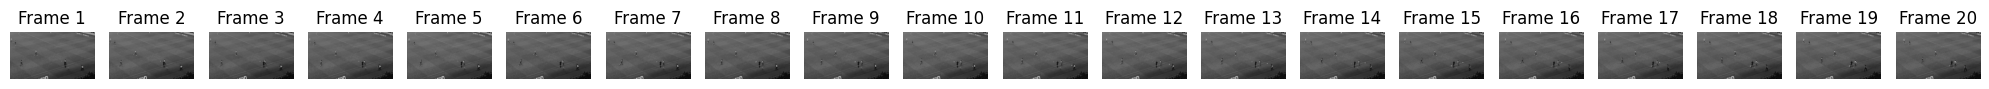


Clip Path: /content/processed_clips_224_new/train/2019-10-01 - Reading - Fulham/368.92_PASS
Assigned Label Index: 8
Assigned Label Name: PASS
Displaying frames for clip: 368.92_PASS


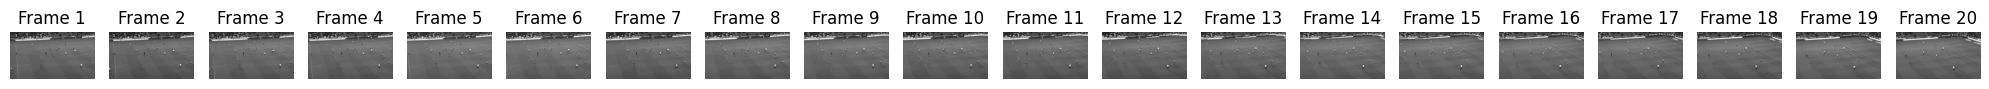


Clip Path: /content/processed_clips_224_new/train/2019-10-01 - Leeds United - West Bromwich/2800.28_PASS
Assigned Label Index: 8
Assigned Label Name: PASS
Displaying frames for clip: 2800.28_PASS


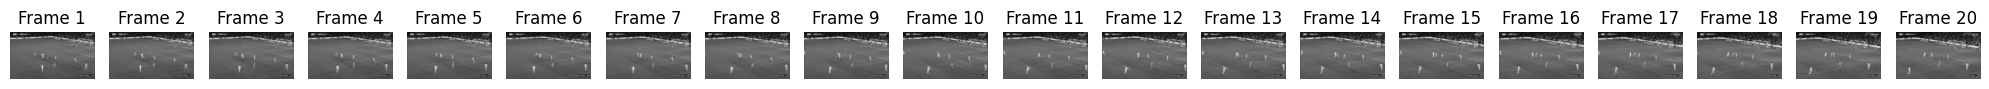


Clip Path: /content/processed_clips_224_new/train/2019-10-01 - Blackburn Rovers - Nottingham Forest/25.64_PASS
Assigned Label Index: 8
Assigned Label Name: PASS
Displaying frames for clip: 25.64_PASS


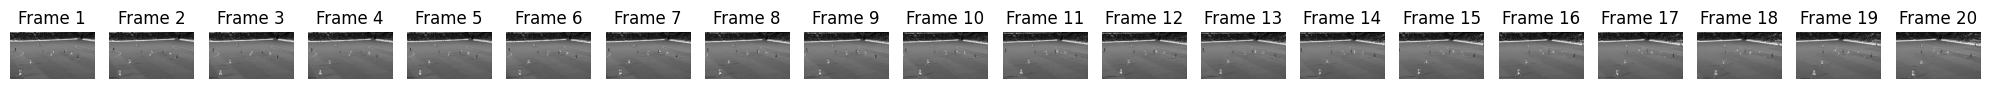


Clip Path: /content/processed_clips_224_new/train/2019-10-01 - Reading - Fulham/4025.32_HIGH PASS
Assigned Label Index: 6
Assigned Label Name: HIGH PASS
Displaying frames for clip: 4025.32_HIGH PASS


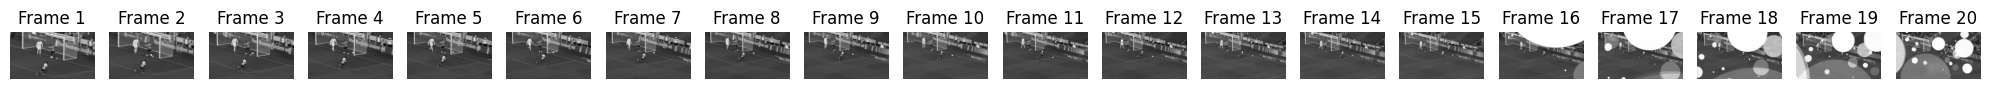

In [ ]:
# Function to load and display frames from a clip folder
def display_clip_frames(clip_folder):
    frame_files = sorted(glob(os.path.join(clip_folder, "*.png")))
    if not frame_files:
        print(f"No frames found in {clip_folder}")
        return

    print(f"Displaying frames for clip: {os.path.basename(clip_folder)}")

    fig, axes = plt.subplots(1, len(frame_files), figsize=(20, 2))
    if len(frame_files) == 1:
        axes = [axes] # Ensure axes is iterable for single frame case

    for i, frame_file in enumerate(frame_files):
        img = cv2.imread(frame_file, cv2.IMREAD_GRAYSCALE)
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Frame {i+1}")
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

# Print labels, label names, and visualize frames for a few random clips
num_clips_to_visualize = 5

print("\nVisualizing a few processed clips:")
if len(train_clip_folders) > 0:
    random_indices = random.sample(range(len(train_clip_folders)), min(num_clips_to_visualize, len(train_clip_folders)))

    for idx in random_indices:
        clip_folder = train_clip_folders[idx]
        label_index = train_label_indices[idx]
        # Find the label name from the index
        label_name = [name for name, index in label_to_index.items() if index == label_index][0]

        print(f"\nClip Path: {clip_folder}")
        print(f"Assigned Label Index: {label_index}")
        print(f"Assigned Label Name: {label_name}")

        display_clip_frames(clip_folder)
else:
    print("No processed clips found to visualize.")

In [ ]:
def count_samples_per_label(labels):
    label_counts = defaultdict(int)
    for label_one_hot in labels:
        label_index = torch.argmax(torch.tensor(label_one_hot)).item()
        label_name = [name for name, index in label_to_index.items() if index == label_index][0]
        label_counts[label_name] += 1
    return label_counts

print("\nTrain set label distribution:")
train_label_counts = count_samples_per_label(train_labels)
for label, count in train_label_counts.items():
    print(f"  Label '{label}': {count} samples")

print("\nValidation set label distribution:")
val_label_counts = count_samples_per_label(val_labels)
for label, count in val_label_counts.items():
    print(f"  Label '{label}': {count} samples")

print("\nTest set label distribution:")
test_label_counts = count_samples_per_label(test_labels)
for label, count in test_label_counts.items():
    print(f"  Label '{label}': {count} samples")



Train set label distribution:
  Label 'HEADER': 458 samples
  Label 'PASS': 3676 samples
  Label 'PLAYER SUCCESSFUL TACKLE': 48 samples
  Label 'DRIVE': 3101 samples
  Label 'HIGH PASS': 547 samples
  Label 'SHOT': 123 samples
  Label 'THROW IN': 250 samples
  Label 'OUT': 391 samples
  Label 'CROSS': 201 samples
  Label 'FREE KICK': 16 samples
  Label 'BALL PLAYER BLOCK': 161 samples
  Label 'GOAL': 11 samples

Validation set label distribution:
  Label 'DRIVE': 645 samples
  Label 'PASS': 722 samples
  Label 'THROW IN': 58 samples
  Label 'HEADER': 128 samples
  Label 'HIGH PASS': 99 samples
  Label 'OUT': 85 samples
  Label 'CROSS': 36 samples
  Label 'BALL PLAYER BLOCK': 34 samples
  Label 'SHOT': 21 samples
  Label 'PLAYER SUCCESSFUL TACKLE': 14 samples
  Label 'FREE KICK': 1 samples
  Label 'GOAL': 1 samples

Test set label distribution:
  Label 'DRIVE': 554 samples
  Label 'PASS': 585 samples
  Label 'BALL PLAYER BLOCK': 28 samples
  Label 'SHOT': 25 samples
  Label 'OUT': 75 s

Labels to keep: 1 (Cross), 2 (Drive), 5 (Header), 6 (High Pass), 8 (Pass), 11 (Thow-in)

## Prepare training data

In [ ]:
# Define the indices of labels to keep
valid_label_names = ["CROSS", "DRIVE", "HEADER", "HIGH PASS", "PASS", "THROW IN"]
labels_to_keep_indices = [label_to_index[name] for name in valid_label_names if name in label_to_index]
labels_to_keep_indices

[1, 2, 5, 6, 8, 11]

In [ ]:
train_augmentations = A.Compose([
    A.HorizontalFlip(p=0.5), # Horizontal Flip
    A.Rotate(limit=15, p=0.5), # Rotation
    A.RandomResizedCrop(size=(224, 398), scale=(0.8, 1.0), ratio=(0.8, 1.2), p=0.5), # Random Resized Crop (spatial per frame)
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5), # Brightness
    A.MotionBlur(blur_limit=5, p=0.5), # Motion Blur
])

Define a custom dataset

In [ ]:
class SoccerNetClipDataset(Dataset):
    def __init__(self, clip_folders, labels, label_to_index, num_frames=20, resize_hw=(224, 398), augmentations=None):
        self.resize_hw = resize_hw
        self.num_frames = num_frames
        self.augmentations = augmentations

        # Define the indices of labels to keep
        valid_label_names = ["CROSS", "DRIVE", "HEADER", "HIGH PASS", "PASS", "THROW IN"]
        self.labels_to_keep_indices = [label_to_index[name] for name in valid_label_names if name in label_to_index]

        # Pre-filter valid clips and keep only the specified labels
        self.valid_data = []
        for folder, label in zip(clip_folders, labels):
            label_tensor = torch.tensor(label, dtype=torch.long) # Ensure label is a long tensor for argmax
            label_index = torch.argmax(label_tensor).item()

            # Check if the label is in the list of labels to keep
            if label_index in self.labels_to_keep_indices:
                 # Check if there are at least num_frames available
                frame_paths = sorted(glob(os.path.join(folder, "*.png")))
                if len(frame_paths) >= self.num_frames:
                     # We only append if we have enough frames to sample num_frames
                    self.valid_data.append((folder, label))
                else:
                    # This print helps identify short clips
                    print(f"Skipping {folder} (only {len(frame_paths)} frames available, need {self.num_frames})")


    def __len__(self):
        return len(self.valid_data)

    def __getitem__(self, idx):
        folder, label = self.valid_data[idx]
        label = torch.tensor(label, dtype=torch.float32)

        frame_paths = sorted(glob(os.path.join(folder, "*.png")))[:self.num_frames]

        frames = []
        for fp in frame_paths:
            img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
            # img = cv2.resize(img, self.resize_hw, interpolation=cv2.INTER_AREA)

            # Apply frame-level augmentations
            if self.augmentations:
                augmented = self.augmentations(image=img)['image']
            else:
                augmented = img

            # Resize the augmented (or original) image to the target size
            resized = cv2.resize(augmented, self.resize_hw[::-1], interpolation=cv2.INTER_AREA)
            # Add channel dimension back (1, resize_h, resize_w)
            frames.append(np.expand_dims(resized, axis=0))

        clip = np.stack(frames, axis=0)  # (num_frames, 1, H, W)
        clip = torch.tensor(clip, dtype=torch.float32) / 255.0

        return clip, label


In [ ]:
batch_size = 16

# Initialise splits
train_set = SoccerNetClipDataset(train_clip_folders, train_labels, label_to_index, augmentations=train_augmentations)
val_set = SoccerNetClipDataset(val_clip_folders, val_labels, label_to_index)
test_set = SoccerNetClipDataset(test_clip_folders, test_labels, label_to_index)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=batch_size//4)
test_loader = DataLoader(test_set, batch_size=batch_size//4)

In [ ]:
# Add weighted sampling to data loader to address class imbalance

# Calculate class weights for weighted sampling
train_labels_indices_filtered = [torch.argmax(torch.tensor(label, dtype=torch.long)).item() for folder, label in train_set.valid_data]

class_counts = np.bincount(train_labels_indices_filtered)
# Ensure that all valid labels are considered, even if some don't appear in the filtered data
num_valid_labels = len(train_set.labels_to_keep_indices)
full_class_counts = np.zeros(num_valid_labels)
# Map original indices to filtered indices for counting
original_to_filtered_index = {original_idx: filtered_idx for filtered_idx, original_idx in enumerate(train_set.labels_to_keep_indices)}

for original_label_idx in train_labels_indices_filtered:
    filtered_label_idx = original_to_filtered_index[original_label_idx]
    full_class_counts[filtered_label_idx] += 1

class_weights = np.where(full_class_counts > 0, 1. / full_class_counts, 0.)
class_weights = class_weights / class_weights.sum() # Normalize

print("Class counts for valid labels in training data (filtered):", full_class_counts)
print("Calculated class weights:", class_weights)

# Create a list of sample weights for the training dataset
sample_weights = []
for folder, label in train_set.valid_data:
    label_index = torch.argmax(torch.tensor(label, dtype=torch.long)).item()
    filtered_label_index = original_to_filtered_index[label_index]
    sample_weights.append(class_weights[filtered_label_index])

# Create a WeightedRandomSampler
sampler = torch.utils.data.WeightedRandomSampler(
    sample_weights,
    num_samples=len(sample_weights), # Sample with replacement for the same number of samples
    replacement=True
)

# Update the DataLoader to use the sampler and set shuffle to False
train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=0, shuffle=False)

print("\nTraining DataLoader updated with WeightedRandomSampler.")

Class counts for valid labels in training data (filtered): [ 201. 3101.  458.  547. 3676.  250.]
Calculated class weights: [0.36632448 0.02374435 0.16076686 0.13460918 0.02003026 0.29452488]

Training DataLoader updated with WeightedRandomSampler.


## Define Loss Function

In [ ]:
@torch.jit.script
def sigmoid_focal_loss(
        inputs: torch.Tensor,
        targets: torch.Tensor,
        alpha: float = -1.0,
        gamma: float = 2.0,
        reduction: str = "mean",
) -> torch.Tensor:

    inputs = inputs.float()
    targets = targets.float()
    p = torch.sigmoid(inputs)
    ce_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    if reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()

    return loss


class FocalLoss(nn.Module):
    def __init__(self, alpha: float = -1.0, gamma: float = 2.0, reduction: str = "mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        return sigmoid_focal_loss(
            inputs, targets,
            alpha=self.alpha,
            gamma=self.gamma,
            reduction=self.reduction
        )

In [ ]:
class EMA:
    def __init__(self, model, decay=0.999):
        self.model = model
        self.decay = decay
        self.shadow = {k: v.clone().detach() for k, v in model.state_dict().items()}

    def update(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                self.shadow[name] = self.decay * self.shadow[name] + (1. - self.decay) * param.data.clone()

    def apply_shadow(self):
        self.backup = {k: v.clone() for k, v in self.model.state_dict().items()}
        self.model.load_state_dict(self.shadow)

    def restore(self):
        self.model.load_state_dict(self.backup)

## Training Setup

In [ ]:
def create_warmup_cosine_scheduler(optimizer, warmup_epochs, total_epochs, base_lr, final_lr):
    def lr_lambda(current_epoch):
        if current_epoch < warmup_epochs:
            return (current_epoch + 1) / warmup_epochs
        progress = (current_epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        cosine = 0.5 * (1 + math.cos(math.pi * progress))
        return cosine * (base_lr - final_lr) / base_lr + final_lr / base_lr
    return LambdaLR(optimizer, lr_lambda)

In [ ]:
# Filter mapping to have only the indices from labels_to_keep_indices
valid_label_to_index = {
    label: idx for label, idx in label_to_index.items() if idx in labels_to_keep_indices
}
print("Filtered Label Map:", valid_label_to_index)

Filtered Label Map: {'CROSS': 1, 'DRIVE': 2, 'HEADER': 5, 'HIGH PASS': 6, 'PASS': 8, 'THROW IN': 11}


In [ ]:
@torch.no_grad()
def validate(model, loader, criterion, threshold=0.5, log_to_wandb=True):
    model.eval()
    total_loss = 0
    all_probs = []
    all_preds = []
    all_labels = []

    index_to_label = {v: k for k, v in valid_label_to_index.items()}

    for clips, labels in tqdm(loader, desc="Validating"):
        clips = clips.to(device)
        labels = labels.to(device)

        outputs = model(clips)
        probs = torch.sigmoid(outputs)

        loss = criterion(outputs, labels)
        total_loss += loss.item()

        preds = (probs > threshold).int()

        all_probs.append(probs.cpu())
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu().int())

    y_true = torch.cat(all_labels).numpy()
    y_pred = torch.cat(all_preds).numpy()
    y_score = torch.cat(all_probs).numpy()

    # Filter to have only valid indices
    valid_indices = list(valid_label_to_index.values())
    y_true = y_true[:, valid_indices]
    y_pred = y_pred[:, valid_indices]
    y_score = y_score[:, valid_indices]

    macro_f1 = f1_score(y_true, y_pred, average='macro')
    per_class_ap = [average_precision_score(y_true[:, i], y_score[:, i]) for i in range(y_true.shape[1])]
    mAP = np.mean(per_class_ap)
    balanced_accs = [balanced_accuracy_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])]
    mccs = [matthews_corrcoef(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])]

    # Logging to wandb
    if log_to_wandb:
      metrics = {
          "val/loss": total_loss / len(loader),
          "val/mAP": mAP,
          "val/macro_F1": macro_f1,
      }
      for i, (ap, ba, mcc) in enumerate(zip(per_class_ap, balanced_accs, mccs)):
          metrics[f"val/class_{i:02d}_AP"] = ap
          metrics[f"val/class_{i:02d}_BalancedAcc"] = ba
          metrics[f"val/class_{i:02d}_MCC"] = mcc

      wandb.log(metrics)

    # Print results for debugging
    print("\n===== Validation Metrics =====")
    print(f"Mean Average Precision (mAP): {mAP:.4f}")
    for i in range(y_true.shape[1]):
        print(f"Class {i:02d} — AP: {per_class_ap[i]:.4f} | BA: {balanced_accs[i]:.4f} | MCC: {mccs[i]:.4f}")
    print("================================\n")

    return total_loss / len(loader), macro_f1, mAP

In [ ]:
# reduce fragmentation
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

# ———————————————————————————————————————————————————————————————
# Configuration (reduced model size & memory tweaks)
# ———————————————————————————————————————————————————————————————
num_classes        = 12
# batch_size         = 16    # already minimal
base_lr            = 3e-4
weight_decay       = 0.01
warmup_epochs      = 1
num_epochs         = 10
final_lr           = 3e-6
steps_per_epoch = len(train_loader)

ema_decay          = 0.9
focal_gamma        = 1.2
device             = "cuda:0"

# SoccerNetHybridModel params — downsized for memory
num_frames         = 20
stack_size         = 4
num_3d_blocks      = 2     # ↓ from 4
num_3d_ch          = 128   # ↓ from 192
proj_ch            = 128   # ↓ from 256
drop_path_rate     = 0.2
checkpoint_dir = "checkpoints_224_v4"

# ———————————————————————————————————————————————————————————————
# Model, Optimizer, Scheduler, Loss, EMA
# ———————————————————————————————————————————————————————————————

# Always initialize the model
model = SoccerNetHybridModel(
    num_classes    = num_classes,
    num_frames     = num_frames,
    stack_size     = stack_size,
    num_3d_blocks  = num_3d_blocks,
    num_3d_ch      = num_3d_ch,
    proj_ch        = proj_ch,
    drop_path_rate = drop_path_rate,
).to(device)

# Freeze 2D backbone
# for param in model.conv2d.parameters():
#     param.requires_grad = False

# # Monkey-patch conv3d with checkpointed version
# _conv3d = model.conv3d
# _segments = len(list(_conv3d))
# class Checkpointed3DEncoder(nn.Module):
#     def __init__(self, blocks, segments):
#         super().__init__()
#         self.blocks = blocks
#         self.segments = segments
#     def forward(self, x):
#         return checkpoint_sequential(self.blocks, self.segments, x)

# model.conv3d = Checkpointed3DEncoder(_conv3d, _segments)

# rebuild optimizer over unfrozen params
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=base_lr,
    weight_decay=weight_decay
)

scheduler = create_warmup_cosine_scheduler(
    optimizer=optimizer,
    warmup_epochs=warmup_epochs,
    total_epochs=num_epochs,
    base_lr=base_lr,
    final_lr=final_lr,
)

criterion = FocalLoss(gamma = focal_gamma)
ema       = EMA(model, decay=ema_decay)
scaler    = GradScaler()

# Load best model if available
# best_model_path = os.path.join(checkpoint_dir, "best_model.pth")
# if os.path.exists(best_model_path):
#     print(f"Loading best model from {best_model_path}")
#     checkpoint = torch.load(best_model_path, map_location=device)

#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
#     start_epoch = checkpoint.get('epoch', 0)
#     print(f"Resumed training from epoch {start_epoch + 1}")

# Early Stopping
early_stopping_patience = 2
epochs_without_improvement = 0
best_map = 0.0

<ipython-input-61-47c940ef2672>:78: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler    = GradScaler()


In [ ]:
# ———————————————————————————————————————————————————————————————
# Weights & Biases Init
# ———————————————————————————————————————————————————————————————
run = wandb.init(
    project="soccernet-action-recognition",
    name="EfficientNetV2-2D3D-hybrid",
    id=run_id,
    resume="must",
    config={
        "batch_size":      batch_size,
        "epochs":          num_epochs,
        "optimizer":       "AdamW",
        "lr":              base_lr,
        "weight_decay":    weight_decay,
        "lr_schedule":     "warmup+cosine",
        "warmup_epochs":   warmup_epochs,
        "final_lr":        final_lr,
        "focal_gamma":     focal_gamma,
        "ema_decay":       ema_decay,
        "num_3d_blocks":   num_3d_blocks,
        "num_3d_ch":       num_3d_ch,
        "proj_ch":         proj_ch,
        "gradient_checkpointing": True,
    }
)

## Training Loop

In [ ]:
best_map = 0.0

os.makedirs(checkpoint_dir, exist_ok=True)
best_train_loss = float('-inf')
for epoch in range(0, num_epochs):
    model.train()
    total_loss = 0.0
    step = 0

    for clips, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):

        # Move inputs as fp16 to cut data footprint in half
        clips  = clips.to(device, dtype=torch.float16, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast():
            outputs = model(clips)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

        # Log to WandB every 100 iterations
        if (step + 1) % 100 == 0:
          wandb.log({
                "iter/train_loss": loss.item(),
                "iter/lr": scheduler.get_last_lr()[0],
                "iter/step": step + epoch * steps_per_epoch,
            }, step=step + epoch * steps_per_epoch)

        step += 1
        # clear cache to fight fragmentation
        torch.cuda.empty_cache()

    scheduler.step()
    current_lr = scheduler.get_last_lr()[0]
    print(f"Epoch {epoch+1}: Train Loss = {total_loss/step:.4f} | LR = {current_lr:.6f}")

    # Log to WandB every epoch
    wandb.log({
        "epoch/epoch":       epoch + 1,
        "epoch/train_loss":  total_loss / step,
        "epoch/lr":          current_lr,
    })
    print(f"Epoch : {epoch+1} | Train Loss: {total_loss/step:.4f} | LR: {current_lr:.6f}")

    # Validation
    val_loss, val_f1, val_map = validate(model, val_loader, criterion)
    print(f"Validation Loss: {val_loss:.4f} | Macro F1: {val_f1:.4f}")

    # Save model based on best validation mAP
    if val_map > best_map:
        best_map = val_map
        best_path = os.path.join(checkpoint_dir, "best_model.pth")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict()
        }, best_path)
        print(f"Saved Best Model (mAP= {val_map:.4f})")

    else:
        epochs_without_improvement += 1  # increment counter
        print(f"No improvement in mAP for {epochs_without_improvement} epoch(s)")

        if epochs_without_improvement >= early_stopping_patience:  # early stopping trigger
            print(f"Early stopping at epoch {epoch+1} (no mAP improvement for {early_stopping_patience} epochs)")
            break

    # Save model every epoch
    model_path = os.path.join(checkpoint_dir, f"model_epoch{epoch+1}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }, model_path)
    print(f"Saved model at epoch {epoch+1}")

with open("wandb_run_id_2.txt", "w") as f:
    f.write(wandb.run.id)

Epoch 1/10:   0%|          | 0/515 [00:00<?, ?it/s]<ipython-input-71-c9fe9c37fd47>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1/10: 100%|██████████| 515/515 [08:55<00:00,  1.04s/it]


Epoch 1: Train Loss = 0.1613 | LR = 0.000291
Epoch : 1 | Train Loss: 0.1613 | LR: 0.000291


Validating: 100%|██████████| 422/422 [00:54<00:00,  7.68it/s]



===== Validation Metrics =====
Mean Average Precision (mAP): 0.2530
Class 00 — AP: 0.2751 | BA: 0.7207 | MCC: 0.3243
Class 01 — AP: 0.4720 | BA: 0.5343 | MCC: 0.1166
Class 02 — AP: 0.0820 | BA: 0.5000 | MCC: 0.0000
Class 03 — AP: 0.1579 | BA: 0.6252 | MCC: 0.1234
Class 04 — AP: 0.4933 | BA: 0.5000 | MCC: 0.0000
Class 05 — AP: 0.0374 | BA: 0.4908 | MCC: -0.0254

Validation Loss: 0.1529 | Macro F1: 0.1181
Saved Best Model (mAP= 0.2530)
Saved model at epoch 1


Epoch 2/10:   0%|          | 0/515 [00:00<?, ?it/s]<ipython-input-71-c9fe9c37fd47>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2/10: 100%|██████████| 515/515 [08:55<00:00,  1.04s/it]


Epoch 2: Train Loss = 0.1032 | LR = 0.000265
Epoch : 2 | Train Loss: 0.1032 | LR: 0.000265


Validating: 100%|██████████| 422/422 [00:54<00:00,  7.70it/s]



===== Validation Metrics =====
Mean Average Precision (mAP): 0.3090
Class 00 — AP: 0.3917 | BA: 0.7246 | MCC: 0.3655
Class 01 — AP: 0.4853 | BA: 0.5472 | MCC: 0.1272
Class 02 — AP: 0.1404 | BA: 0.5029 | MCC: 0.0321
Class 03 — AP: 0.1828 | BA: 0.5816 | MCC: 0.1347
Class 04 — AP: 0.5118 | BA: 0.4991 | MCC: -0.0175
Class 05 — AP: 0.1419 | BA: 0.5527 | MCC: 0.1407

Validation Loss: 0.1120 | Macro F1: 0.1738
Saved Best Model (mAP= 0.3090)
Saved model at epoch 2


Epoch 3/10:   0%|          | 0/515 [00:00<?, ?it/s]<ipython-input-71-c9fe9c37fd47>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3/10: 100%|██████████| 515/515 [08:56<00:00,  1.04s/it]


Epoch 3: Train Loss = 0.0863 | LR = 0.000226
Epoch : 3 | Train Loss: 0.0863 | LR: 0.000226


Validating: 100%|██████████| 422/422 [00:54<00:00,  7.71it/s]



===== Validation Metrics =====
Mean Average Precision (mAP): 0.3563
Class 00 — AP: 0.4420 | BA: 0.7246 | MCC: 0.3655
Class 01 — AP: 0.5140 | BA: 0.5825 | MCC: 0.1780
Class 02 — AP: 0.1900 | BA: 0.5108 | MCC: 0.0957
Class 03 — AP: 0.2214 | BA: 0.5679 | MCC: 0.2098
Class 04 — AP: 0.5249 | BA: 0.5156 | MCC: 0.0720
Class 05 — AP: 0.2455 | BA: 0.6626 | MCC: 0.2772

Validation Loss: 0.0906 | Macro F1: 0.2496
Saved Best Model (mAP= 0.3563)
Saved model at epoch 3


Epoch 4/10:   0%|          | 0/515 [00:00<?, ?it/s]<ipython-input-71-c9fe9c37fd47>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4/10: 100%|██████████| 515/515 [08:55<00:00,  1.04s/it]


Epoch 4: Train Loss = 0.0804 | LR = 0.000177
Epoch : 4 | Train Loss: 0.0804 | LR: 0.000177


Validating: 100%|██████████| 422/422 [00:54<00:00,  7.74it/s]



===== Validation Metrics =====
Mean Average Precision (mAP): 0.3792
Class 00 — AP: 0.4637 | BA: 0.8037 | MCC: 0.4259
Class 01 — AP: 0.5254 | BA: 0.5820 | MCC: 0.1809
Class 02 — AP: 0.2127 | BA: 0.5143 | MCC: 0.1106
Class 03 — AP: 0.2527 | BA: 0.5669 | MCC: 0.2554
Class 04 — AP: 0.5397 | BA: 0.5306 | MCC: 0.1090
Class 05 — AP: 0.2808 | BA: 0.7132 | MCC: 0.2738

Validation Loss: 0.0845 | Macro F1: 0.2680
Saved Best Model (mAP= 0.3792)
Saved model at epoch 4


Epoch 5/10:   0%|          | 0/515 [00:00<?, ?it/s]<ipython-input-71-c9fe9c37fd47>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5/10: 100%|██████████| 515/515 [08:54<00:00,  1.04s/it]


Epoch 5: Train Loss = 0.0754 | LR = 0.000126
Epoch : 5 | Train Loss: 0.0754 | LR: 0.000126


Validating: 100%|██████████| 422/422 [00:54<00:00,  7.70it/s]



===== Validation Metrics =====
Mean Average Precision (mAP): 0.4036
Class 00 — AP: 0.5062 | BA: 0.8991 | MCC: 0.5188
Class 01 — AP: 0.5377 | BA: 0.5976 | MCC: 0.1997
Class 02 — AP: 0.2175 | BA: 0.5140 | MCC: 0.1019
Class 03 — AP: 0.3321 | BA: 0.5723 | MCC: 0.2759
Class 04 — AP: 0.5511 | BA: 0.5286 | MCC: 0.1134
Class 05 — AP: 0.2769 | BA: 0.7243 | MCC: 0.2943

Validation Loss: 0.0810 | Macro F1: 0.2905
Saved Best Model (mAP= 0.4036)
Saved model at epoch 5


Epoch 6/10:   0%|          | 0/515 [00:00<?, ?it/s]<ipython-input-71-c9fe9c37fd47>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6/10: 100%|██████████| 515/515 [08:53<00:00,  1.04s/it]


Epoch 6: Train Loss = 0.0732 | LR = 0.000077
Epoch : 6 | Train Loss: 0.0732 | LR: 0.000077


Validating: 100%|██████████| 422/422 [00:54<00:00,  7.76it/s]



===== Validation Metrics =====
Mean Average Precision (mAP): 0.4121
Class 00 — AP: 0.5133 | BA: 0.8457 | MCC: 0.4787
Class 01 — AP: 0.5425 | BA: 0.6001 | MCC: 0.2022
Class 02 — AP: 0.2146 | BA: 0.5101 | MCC: 0.0780
Class 03 — AP: 0.3823 | BA: 0.5770 | MCC: 0.2834
Class 04 — AP: 0.5526 | BA: 0.5311 | MCC: 0.1196
Class 05 — AP: 0.2671 | BA: 0.7489 | MCC: 0.3196

Validation Loss: 0.0784 | Macro F1: 0.2929
Saved Best Model (mAP= 0.4121)
Saved model at epoch 6


Epoch 7/10:   0%|          | 0/515 [00:00<?, ?it/s]<ipython-input-71-c9fe9c37fd47>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7/10: 100%|██████████| 515/515 [08:53<00:00,  1.04s/it]


Epoch 7: Train Loss = 0.0718 | LR = 0.000038
Epoch : 7 | Train Loss: 0.0718 | LR: 0.000038


Validating: 100%|██████████| 422/422 [00:54<00:00,  7.71it/s]



===== Validation Metrics =====
Mean Average Precision (mAP): 0.4233
Class 00 — AP: 0.5392 | BA: 0.8590 | MCC: 0.4881
Class 01 — AP: 0.5448 | BA: 0.6103 | MCC: 0.2176
Class 02 — AP: 0.2206 | BA: 0.5101 | MCC: 0.0780
Class 03 — AP: 0.4009 | BA: 0.5777 | MCC: 0.2964
Class 04 — AP: 0.5644 | BA: 0.5361 | MCC: 0.1312
Class 05 — AP: 0.2700 | BA: 0.7517 | MCC: 0.3055

Validation Loss: 0.0784 | Macro F1: 0.2998
Saved Best Model (mAP= 0.4233)
Saved model at epoch 7


Epoch 8/10:   0%|          | 0/515 [00:00<?, ?it/s]<ipython-input-71-c9fe9c37fd47>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8/10: 100%|██████████| 515/515 [08:53<00:00,  1.04s/it]


Epoch 8: Train Loss = 0.0701 | LR = 0.000012
Epoch : 8 | Train Loss: 0.0701 | LR: 0.000012


Validating: 100%|██████████| 422/422 [00:54<00:00,  7.75it/s]



===== Validation Metrics =====
Mean Average Precision (mAP): 0.4219
Class 00 — AP: 0.5415 | BA: 0.8590 | MCC: 0.4881
Class 01 — AP: 0.5389 | BA: 0.6124 | MCC: 0.2206
Class 02 — AP: 0.2212 | BA: 0.5140 | MCC: 0.1019
Class 03 — AP: 0.4135 | BA: 0.5827 | MCC: 0.3098
Class 04 — AP: 0.5609 | BA: 0.5475 | MCC: 0.1592
Class 05 — AP: 0.2552 | BA: 0.7499 | MCC: 0.2986

Validation Loss: 0.0786 | Macro F1: 0.3112
No improvement in mAP for 1 epoch(s)
Saved model at epoch 8


Epoch 9/10:   0%|          | 0/515 [00:00<?, ?it/s]<ipython-input-71-c9fe9c37fd47>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9/10: 100%|██████████| 515/515 [08:54<00:00,  1.04s/it]


Epoch 9: Train Loss = 0.0697 | LR = 0.000003
Epoch : 9 | Train Loss: 0.0697 | LR: 0.000003


Validating: 100%|██████████| 422/422 [00:54<00:00,  7.74it/s]



===== Validation Metrics =====
Mean Average Precision (mAP): 0.4264
Class 00 — AP: 0.5469 | BA: 0.8596 | MCC: 0.4949
Class 01 — AP: 0.5560 | BA: 0.6137 | MCC: 0.2279
Class 02 — AP: 0.2207 | BA: 0.5196 | MCC: 0.1010
Class 03 — AP: 0.4169 | BA: 0.5871 | MCC: 0.3099
Class 04 — AP: 0.5612 | BA: 0.5443 | MCC: 0.1467
Class 05 — AP: 0.2568 | BA: 0.7548 | MCC: 0.2951

Validation Loss: 0.0781 | Macro F1: 0.3139
Saved Best Model (mAP= 0.4264)
Saved model at epoch 9


Epoch 10/10:   0%|          | 0/515 [00:00<?, ?it/s]<ipython-input-71-c9fe9c37fd47>:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10/10: 100%|██████████| 515/515 [08:55<00:00,  1.04s/it]


Epoch 10: Train Loss = 0.0697 | LR = 0.000012
Epoch : 10 | Train Loss: 0.0697 | LR: 0.000012


Validating: 100%|██████████| 422/422 [00:54<00:00,  7.71it/s]


===== Validation Metrics =====
Mean Average Precision (mAP): 0.4247
Class 00 — AP: 0.5483 | BA: 0.8846 | MCC: 0.4973
Class 01 — AP: 0.5503 | BA: 0.6134 | MCC: 0.2259
Class 02 — AP: 0.2211 | BA: 0.5140 | MCC: 0.1019
Class 03 — AP: 0.4129 | BA: 0.5833 | MCC: 0.3242
Class 04 — AP: 0.5533 | BA: 0.5344 | MCC: 0.1192
Class 05 — AP: 0.2621 | BA: 0.7619 | MCC: 0.2991

Validation Loss: 0.0796 | Macro F1: 0.3034
No improvement in mAP for 2 epoch(s)
Early stopping at epoch 10 (no mAP improvement for 2 epochs)


In [ ]:
wandb_dir = "wandb"
run_dirs = [d for d in os.listdir(wandb_dir) if d.startswith("run-")]
latest_run = sorted(run_dirs, key=lambda x: os.path.getmtime(os.path.join(wandb_dir, x)))[-1]
run_id = latest_run.split("-")[-1]
print("Recovered latest run ID:", run_id)

Recovered latest run ID: pnk5hvpd


## Evaluation

In [ ]:
test_loss, test_f1, test_map = validate(model, test_loader, criterion, log_to_wandb=False)
print(f"Test Loss: {test_loss:.4f} | Macro F1: {test_f1:.4f} | mAP: {test_map:.4f}")

Validating: 100%|██████████| 365/365 [00:46<00:00,  7.78it/s]


===== Validation Metrics =====
Mean Average Precision (mAP): 0.4077
Class 00 — AP: 0.3851 | BA: 0.7961 | MCC: 0.3735
Class 01 — AP: 0.5683 | BA: 0.6245 | MCC: 0.2631
Class 02 — AP: 0.3154 | BA: 0.6119 | MCC: 0.2755
Class 03 — AP: 0.3472 | BA: 0.5347 | MCC: 0.1569
Class 04 — AP: 0.5349 | BA: 0.5196 | MCC: 0.1138
Class 05 — AP: 0.2954 | BA: 0.7265 | MCC: 0.2842

Test Loss: 0.0817 | Macro F1: 0.2824 | mAP: 0.4077


## Moving stuff around

In [ ]:
import shutil
folder_path = "/content/Dribble.AI/processed_clips_224_v2"
zip_path = '/content/processed_clips_v2.zip'

shutil.make_archive(base_name='/content/processed_clips_v2', format='zip', root_dir=folder_path)

'/content/processed_clips_v2.zip'

In [ ]:
target_zip_path = "/content/drive/MyDrive/Dribble.AI/processed_clips_v2.zip"
shutil.copy(zip_path, target_zip_path)
print(f"Copied {zip_path} to {target_zip_path}")

Copied /content/processed_clips_v2.zip to /content/drive/MyDrive/Dribble.AI/processed_clips_v2.zip


In [ ]:
from google.colab import files
files.download(zip_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>